Training a qcgan with a gamma function with 6 parameters (1 layer)

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib.offsetbox import AnchoredText
import pandas as pd

[Qibo 0.1.7|INFO|2022-07-03 10:48:05]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-07-03 10:48:05]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-07-03 10:48:06]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-07-03 10:48:06]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


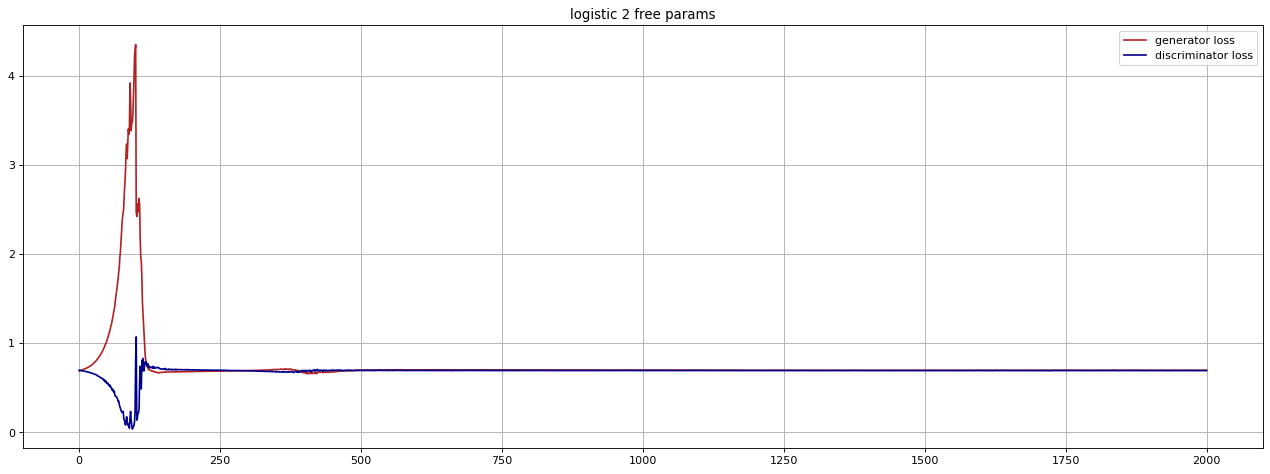

In [2]:
epochs=2000
d_loss = np.loadtxt(f"dloss_1Dlogistic_1_3_0_10000_128_0.1_{epochs}", delimiter=' ',)
g_loss= np.loadtxt(f"gloss_1Dlogistic_1_3_0_10000_128_0.1_{epochs}", delimiter=' ')
d_loss=d_loss[:10000]
g_loss=g_loss[:10000]
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss',color="firebrick")
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss',color="darkblue")
pyplot.legend()
pyplot.title("logistic 2 free params")
pyplot.grid()
pyplot.show()
 

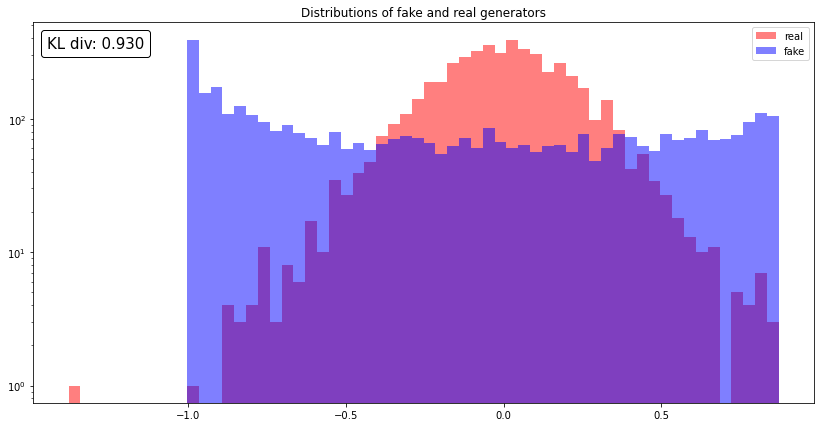

In [19]:
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems


# number of qubits generator
nqubits = 1
# create hamiltonians
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=5000
nqubits=1
layers=0
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

params = np.loadtxt(f"PARAMS_1Dlogistic_1_3_0_10000_128_0.1_{epochs}_2", delimiter=' ', unpack='true')
#print(params,epochs)
params = tf.Variable(params)
distributions=[]

x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)

#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
fig, ax = pyplot.subplots(figsize = (14, 7))
s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 3000)


ax.set_yscale('log')
nbins=60
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

distributions.append(x_real)
distributions.append(x_fake)

pyplot.yscale('log')
pyplot.legend()
pyplot.title("Distributions of fake and real generators")

ax=pyplot.gca()
at = AnchoredText(
f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

pyplot.show()

0 0.046841171886198345
1 0.037969990914772815
2 0.05468903622086976
3 0.04781675114712583
4 0.053712166696785496
5 0.051840800572660065
6 0.04638158632783082
7 0.04317839200334722
8 0.04787857705632296
9 0.044258858672636875
10 0.045110856573239565
11 0.049939118484742785
12 0.051304336660579125
13 0.04553807357995196
14 0.04826577586920824
15 0.035643455581556904
16 0.04852001048566166
17 0.05688720917587186
18 0.04820359285418088
19 0.03878623333021204
20 0.046044760125402366
21 0.04439522346884068
22 0.060503936417682966
23 0.04040834527425288
24 0.05842542921247343
25 0.041400868507592434
26 0.03213509465536565
27 0.046401157182342986
28 0.052830573212406626
29 0.05167543717204798
30 0.046817460213469025
31 0.0455169086222219
32 0.04801201582905392
33 0.04994835006696587


KeyboardInterrupt: 

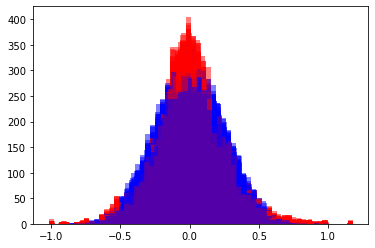

In [18]:
kl = []
s=qc.generate_training_real_samples(samples)
for i in range(100):
    
    x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)
    x_real, y_real = qc.generate_real_samples(samples, s, 3000)


   
    nbins=60
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

    kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))
    print(i,kl[i])
print(kl)

Calculation of the kl divergences: This formula has a problem: if there are bins with no elements the kl divergence diverges, this problem can be solved adding a small quantity at each bin.

In [4]:
from IPython.display import display
from scipy import stats

moments = pd.DataFrame(
    {
        "distribution":["real","fake 100000" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment ":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment ":[stats.moment(i,moment=4)[0] for i in distributions]
    }
)

display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real,0.003316,0.052675,-0.000486,0.011200
1,fake 100000,0.004227,0.058732,-0.000190,0.009619


In [7]:
np.savetxt('fake_data_2params.dat',x_fake)

In [22]:
from scipy import stats
stat_moments_mean= []
stat_moments_err= []
samples = 3000 



   
    
moments = [[] for j in range(4)]
for k in range(4):
    params = np.loadtxt(f"PARAMS_1Dlogistic_1_3_0_10000_128_0.1_{epochs}_{k}", delimiter=' ', unpack='true')
    params = tf.Variable(params)    
    x_fake, _ = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)

    moments[0].append(np.mean(x_fake))
    moments[1].append(stats.moment(x_fake,moment=2)[0])
    moments[2].append(stats.moment(x_fake,moment=3)[0])
    moments[3].append(stats.moment(x_fake,moment=4)[0])

for k in range(len(moments)): 

    stat_moments_mean.append(np.mean(moments[k]))
    stat_moments_err.append(stats.moment(moments[k],moment=2))

print(stat_moments_mean, stat_moments_err)

[-0.0003378647686086728, 0.17255631035423036, -0.003458096198881845, 0.10291652175980824] [0.00011228982964860808, 0.036582215230388876, 3.683545914735109e-05, 0.025480221055107943]
